In [1]:
## ========================== Import Package ========================== ##

import numpy as np
import math
import matplotlib.pyplot as plt
import time

## ========================== Parameter Declaration ========================== ##

filter_order = 6
train_sample = 200
num_repeat = 1

## =========================== Generate Sampeles =========================== ##

signal_xy = np.loadtxt('sun_spot_input.asc')
signal_xy = signal_xy/max(signal_xy)

signal_x_train = np.array([signal_xy[i-filter_order:i][::-1] for i in range(filter_order, train_sample + filter_order)])
signal_y_train = signal_xy[filter_order:train_sample + filter_order]

signal_x_train_repeat = signal_x_train.copy()
signal_y_train_repeat = signal_y_train.copy()
for i in range (num_repeat):
    signal_x_train_repeat = np.vstack((signal_x_train_repeat, signal_x_train_repeat))
    signal_y_train_repeat = np.hstack((signal_y_train_repeat, signal_y_train_repeat))

signal_x_test = np.array([signal_xy[i-filter_order:i][::-1] for i in range(train_sample + filter_order, len(signal_xy))])
signal_y_test = signal_xy[train_sample + filter_order:len(signal_xy)]

In [2]:
# QKLMS Algorithm

mu_vector = np.array([0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1]) # step size
h_x = 1 / (2 * 1 ** 2) # parameter of Gaussian kernel
delta = 0.05 # quantization threshold

# define kernel
def kernel(x1, x2, h):
    return np.exp(-h * np.sum((x1 - x2) ** 2, axis = 1))


# define QKLMS

QKLMS_trainMSE_store = np.zeros((len(mu_vector), len(signal_x_train_repeat)))
QKLMS_testMSE_store = np.zeros((len(mu_vector), len(signal_x_train_repeat)))

QKLMS_start = time.time()
for mmm in range (len(mu_vector)):
    mu = mu_vector[mmm]
    
    QKLMS_center_list = []
    QKLMS_alpha_list = []
    QKLMS_network_size = []
    
    for i in range (len(signal_x_train_repeat)):
        if i == 0:
            filter_output = 0
            QKLMS_alpha_list.append(mu * (signal_y_train_repeat[i] - filter_output))
            QKLMS_center_list.append(signal_x_train_repeat[i])
        else:
            filter_output = np.array(QKLMS_alpha_list) @ kernel(signal_x_train_repeat[i], np.array(QKLMS_center_list), h_x)            
            if i <= 1:
                dist_min = np.linalg.norm(signal_x_train_repeat[i] - np.array(QKLMS_center_list))
                dist_min_index = np.argmin(dist_min)
            else:
                dist_store = np.linalg.norm(signal_x_train_repeat[i] - np.array(QKLMS_center_list), axis = 1)
                dist_min_index = np.argmin(dist_store)
                dist_min = min(dist_store)
            if dist_min <= delta:
                QKLMS_alpha_list[dist_min_index] = QKLMS_alpha_list[dist_min_index] + mu * (signal_y_train_repeat[i] - filter_output)
            else:
                QKLMS_alpha_list.append(mu * (signal_y_train_repeat[i] - filter_output))
                QKLMS_center_list.append(signal_x_train_repeat[i])
                
        QKLMS_train_error = np.zeros(len(signal_x_train))
        QKLMS_test_error = np.zeros(len(signal_x_test))
        for iii in range(len(signal_x_train)): 
            QKLMS_train_error[iii] = np.array(QKLMS_alpha_list) @ kernel(signal_x_train[iii], np.array(QKLMS_center_list), h_x)
        for jjj in range(len(signal_x_test)): 
            QKLMS_test_error[jjj] = np.array(QKLMS_alpha_list) @ kernel(signal_x_test[jjj], np.array(QKLMS_center_list), h_x)
        QKLMS_trainMSE_store[mmm][i] = np.sum((signal_y_train - QKLMS_train_error) ** 2) / len(signal_y_train)
        QKLMS_testMSE_store[mmm][i] = np.sum((signal_y_test - QKLMS_test_error) ** 2) / len(signal_y_test)
        QKLMS_network_size.append(len(QKLMS_center_list))

QKLMS_end = time.time()
print('The time of execution using QKLMS:', QKLMS_end - QKLMS_start)

The time of execution using QKLMS: 334.609925031662


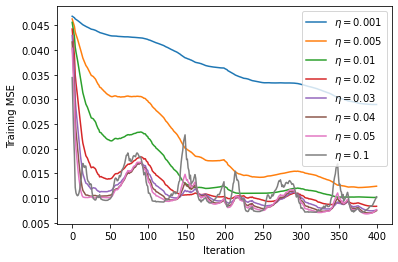

In [3]:
# Learning curve of training MSE

l1 = plt.plot(QKLMS_trainMSE_store[0])
l2 = plt.plot(QKLMS_trainMSE_store[1])
l3 = plt.plot(QKLMS_trainMSE_store[2])
l4 = plt.plot(QKLMS_trainMSE_store[3])
l5 = plt.plot(QKLMS_trainMSE_store[4])
l6 = plt.plot(QKLMS_trainMSE_store[5])
l7 = plt.plot(QKLMS_trainMSE_store[6])
l8 = plt.plot(QKLMS_trainMSE_store[7])
plt.xlabel('Iteration')
plt.ylabel('Training MSE')
plt.legend([r'$\eta=0.001$', r'$\eta=0.005$', r'$\eta=0.01$', r'$\eta=0.02$', r'$\eta=0.03$', r'$\eta=0.04$', r'$\eta=0.05$', r'$\eta=0.1$'])
plt.show()

In [6]:
QKLMS_trainMSE_store[:, -1]

array([0.02896043, 0.01240176, 0.010129  , 0.00833508, 0.00758842,
       0.00744768, 0.00764825, 0.01024928])

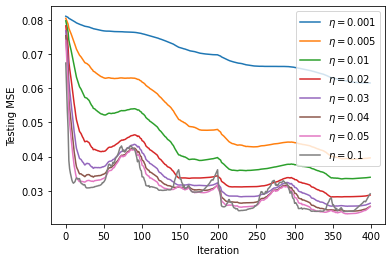

In [4]:
# Learning curve of testing MSE

l1 = plt.plot(QKLMS_testMSE_store[0])
l2 = plt.plot(QKLMS_testMSE_store[1])
l3 = plt.plot(QKLMS_testMSE_store[2])
l4 = plt.plot(QKLMS_testMSE_store[3])
l5 = plt.plot(QKLMS_testMSE_store[4])
l6 = plt.plot(QKLMS_testMSE_store[5])
l7 = plt.plot(QKLMS_testMSE_store[6])
l8 = plt.plot(QKLMS_testMSE_store[7])
plt.xlabel('Iteration')
plt.ylabel('Testing MSE')
plt.legend([r'$\eta=0.001$', r'$\eta=0.005$', r'$\eta=0.01$', r'$\eta=0.02$', r'$\eta=0.03$', r'$\eta=0.04$', r'$\eta=0.05$', r'$\eta=0.1$'])
plt.show()

In [7]:
QKLMS_testMSE_store[:, -1]

array([0.06150467, 0.03960876, 0.03394483, 0.02875679, 0.02634876,
       0.02543591, 0.02534619, 0.02911048])

In [5]:
## =================================================== Q1 AND Q2 ======================================================##